In [3]:
from typing import Tuple, Dict

import h5py
import pandas as pd
import numpy as np
from joblib import load, dump
from umap import UMAP
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, GridSearchCV 
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

plt.style.use("publication")

In [4]:
def standardize_test(estimator: "sklearn model", search_params: Tuple[Dict], data: Tuple[np.ndarray, np.ndarray]):
    # split data into X and y for regression
    X, y = data
    # Manually specify 10-fold cross-validation for the grid search
    kfold = KFold(10, random_state=42, shuffle=True)
    grid_search = GridSearchCV(
        estimator, search_params, scoring="neg_mean_squared_error", cv=kfold, n_jobs=4
    )
    # run the grid search
    grid_search.fit(X, y)
    # give some summary statistics
    y_mask = y != 0.
    y_pred = grid_search.best_estimator_.predict(X)
    mse = metrics.mean_squared_error(y_pred, y)
    masked_mse = metrics.mean_squared_error(y_pred[y_mask], y[y_mask])
    print(f"Best MSE: {mse:.4f}")
    print(f"Best masked MSE: {masked_mse:.4f}")
    return grid_search, grid_search.best_estimator_

## Setting molecules with no chance of observing to zero column

In [5]:
data = h5py.File("../../data/processed/smiles_embeddings_300.h5", "r")

In [6]:
data.keys()

<KeysViewHDF5 ['cluster_ids', 'pca', 'smiles', 'vectors']>

In [7]:
pipeline = load("../../models/embedding_pipeline.pkl")
pca = load("../../models/pca_model.pkl")

In [8]:
tmc1_df = pd.read_pickle("../../data/interim/tmc1_table_vecs.pkl")

# tmc1_df = tmc1_df.loc[tmc1_df["Formula"] != "H2"]

tmc1_df.reset_index(inplace=True, drop=True)

In [9]:
tmc1_vecs = np.vstack(tmc1_df["Vecs"])

In [10]:
# Here we purposefully withdraw some classes of molecules to see
# how well these are reproduced
holdout_df = tmc1_df.loc[~tmc1_df["Formula"].isin(["HC5N", "HC9N", "CH3C4H"])]

In [11]:
holdout_df

Molecule   Formula       SMILES  Column density (cm^-2)  \
0       Methyltriacetylene    CH3C6H   C#CC#CC#CC            3.100000e+12   
2   Methylcyanodiacetylene    CH3C5N   CC#CC#CC#N            8.400000e+11   
3     Methylcyanoacetylene    CH3C3N      CC#CC#N            1.800000e+12   
4      Protonated nitrogen      N2H+      N#[NH+]            5.000000e+12   
5                  Ammonia       NH3            N            5.010000e+14   
..                     ...       ...          ...                     ...   
79     Protonated cyanogen    NCCNH+   N#CC#[NH+]            8.600000e+10   
80                     NaN      C6H2  C=C=C=C=C=C            2.130000e+10   
81               Propylene  CH3CHCH2         C=CC            4.000000e+13   
82             Cyanoallene  CH2C2HCN     C=C=CC#N            4.500000e+11   
83        Hydrogen cyanide       HCN          C#N            2.450000e+12   

                            DOI  Isotopologue  Upper Limit  \
0                10.1086/504918             0            0   
2                10.1086/504918             0            0   
3                10.1086/504918             0            0   
4      10.3847/1538-4365/aa69ba             0            0   
5    10.3847/0067-0049/225/2/25             0            0   
..                          ...           ...          ...   
79  10.1051/0004-6361/201526650             0            0   
80               10.1086/310622             0            0   
81               10.1086/521398             0            0   
82               10.1086/500431             0            0   
83               10.1086/306032             0            0   

                                               Notes  \
0                                            Remijan   
2                                            Remijan   
3                                            Remijan   
4                           FCRAO, 1 - 0; towards CP   
5                                   Kaifu survey obs   
..                                               ...   
79                                             Yebes   
80       NASA DSN 70m; converted assuming H2 density   
81                                          IRAM 30m   
82                                          GBT 100m   
83  Based on abundance ratio; HCN is optically thick   

                                                 Vecs  
0   [2.0953827, -4.50535, 0.52709067, -1.2093838, ...  
2   [1.207319, -5.1080704, -0.039868705, -1.834622...  
3   [1.1559796, -3.068057, -0.3394103, -1.3995979,...  
4   [0.11407158, -0.76171607, -0.95510256, -0.7127...  
5   [-0.09987478, -0.032913096, -0.81312376, -0.03...  
..                                                ...  
79  [0.35317123, -3.2156177, -2.2517192, -2.456177...  
80  [1.2601768, -4.890073, -1.674466, -1.8292549, ...  
81  [1.0377933, 0.99821156, -0.22186852, -1.248241...  
82  [1.6163945, -3.59433, -0.6654961, -1.8897333, ...  
83  [0.2618229, -0.8566673, -0.3519507, -0.3567893...  

[81 rows x 9 columns]

In [12]:
holdout_vecs = np.vstack(holdout_df["Vecs"])

In [13]:
pipeline

Pipeline(steps=[('incrementalpca', IncrementalPCA(n_components=100)),
                ('kmeans', KMeans(n_clusters=20, random_state=42))])

In [14]:
tmc1_cluster_ids = pipeline.predict(tmc1_vecs).compute()
holdout_cluster_ids = pipeline.predict(holdout_vecs).compute()

In [15]:
tmc1_embedding = pipeline.steps[0][1].transform(tmc1_vecs)
holdout_embedding = pipeline.steps[0][1].transform(holdout_vecs)

In [16]:
holdout_y = np.log10(holdout_df["Column density (cm^-2)"].to_numpy())

## Prepping data

In [17]:
indices = np.arange(len(data["pca"]))

rng = np.random.default_rng(42)

mask = np.zeros_like(data["cluster_ids"], dtype=bool)
for i in np.unique(tmc1_cluster_ids):
    mask += data["cluster_ids"][:] == i

In [18]:
# Extract out the molecules contained within our cluster
all_pca = (data["pca"][:])[mask,:]
subset_smiles = (data["smiles"][:])[mask]

In [19]:
X = tmc1_embedding
Y = tmc1_df["Column density (cm^-2)"].to_numpy()
Y = np.log10(Y)
shift = Y.mean()
# Y -= shift

In [20]:
# calculate pairwise distances between TMC-1 molecules and all others
distances = cosine_distances(tmc1_embedding, all_pca)

In [40]:
dist_mask = distances.mean(axis=0) > 0.88

In [41]:
# this counts the number of molecules we're artificially constraining
dist_mask.sum()

199

### What molecules are we setting to zero?

You can expand the cell below to see SMILES for the molecules we're zeroing

In [27]:
subset_smiles[dist_mask]

array(['CC(=O)NC(C(=O)CC(N)C(=O)O)C(O)C(O)C(O)CO',
       'CC(C)=CCCC1(C)CC1COP(=O)(O)OP(=O)(O)O',
       'C[Si](C)(C)C([Pb]C([Si](C)(C)C)[Si](C)(C)C)[Si](C)(C)C',
       'NC(=O)C1C(N=NC2=NO[N+]([O-])=C2C(N)=O)=NO[N+]=1[O-]',
       'C[N+](C)(C)CCCC1C2CCC(C2)C1C[N+](C)(C)C',
       'CCCCCCCCNS(=O)(=O)CCNC1CCCCC1',
       'CC(C)(C)C(=NN=C(C(C)(C)C)C(C)(C)C)C(C)(C)C',
       'CCC1=CC=CC(CC)=C1N1C(N)=NC(N)=NC1(C)C.Cl',
       'CCCN1N=C(N=C1C1=NON=C1N)C1=NON=C1N',
       'CCN(CC)P(C1CC(C)CCC1C(C)C)N(CC)CC',
       'CC1=CCC(CC1)C(C)(CO[Si](C)(C)C)O[Si](C)(C)C',
       'CC(=O)NC(C(O)C(F)C(=O)C(=O)O)C(O)C(O)C(O)CO',
       'C1=CC2C=CC3C=CC[N-]C=3C=2[N-]C1.CC[Sn](F)(F)CC',
       'CC(=NN=C(N)N)C1=CC=CC(=C1)C(C)=NN=C(N)N',
       'CC(C)=CCCC(C)=CCCC(C)=CCSCC(=O)O',
       'CC(C)CCCC(C)CCCC(C)(O)CCCC(C)C',
       'CC(CCNCCNCCC(C)CC(C)(C)C)CC(C)(C)C',
       'O=C(CO)C(O)C(O)C(O)CO.O=CC(O)C(O)C(O)C(O)CO',
       'CC1CC(C)(C)N(N=1)C1N=C(N)N=C(CN2C=CN=C2)N=1',
       'CC(CN(CC(C)OCC1CO1)C(C)(C)C)OCC

In [42]:
dummies = all_pca[dist_mask]
dummy_y = np.zeros(len(dummies))

In [43]:
# add the constrained values to our training data
train_x = np.vstack([X, dummies])
train_y = np.hstack([Y, dummy_y])

In [44]:
holdout_train_x = np.vstack([holdout_embedding, dummies])
holdout_train_y = np.hstack([holdout_y, dummy_y])

## Linear regression

In [45]:
linear_tuning = [{"normalize": [True, False], "fit_intercept": [True, False]}]

In [46]:
linear_grid, linear_model = standardize_test(LinearRegression(), linear_tuning, (train_x, train_y))

Best MSE: 0.6153
Best masked MSE: 1.6909


In [47]:
linear_cols = linear_model.predict(all_pca)

## Support vector machines

In [65]:
svm_search, svm_model = standardize_test(
    SVR(), [{"kernel": ["linear", "rbf", "poly"], "degree": [2, 3, 4, 5], "C": np.linspace(0.2, 2., 10)}], (train_x, train_y)
)

Best MSE: 0.7605
Best masked MSE: 2.5405


In [70]:
svm_search.best_estimator_

SVR(C=2.0, degree=2)

In [66]:
dump(svm_search, "../../models/svm_grid.pkl")

['../../models/svm_grid.pkl']

In [67]:
svm_cols = svm_model.predict(all_pca)

## $k$-nearest neighbors

In [48]:
knn_search, knn = standardize_test(
    KNeighborsRegressor(algorithm="brute"),
    [{"n_neighbors": [2, 4, 5, 6, 8, 10, 15, 30, 50, 100], "metric": ["cosine", "euclidean"]}],
    (train_x, train_y)
)

Best MSE: 0.5640
Best masked MSE: 1.9002


In [49]:
knn_search.best_params_

{'metric': 'cosine', 'n_neighbors': 8}

In [50]:
# predict column densities with k-NN
knn_cols = knn.predict(all_pca)

In [51]:
dump(knn_search, "../../models/knn_grid.pkl")

['../../models/knn_grid.pkl']

## Ensemble methods

### Random Forest regression

In [52]:
gbr_tuning = [{"learning_rate": 10**np.linspace(-3., 1., 5), "n_estimators": [80, 100, 125, 150], "subsample": np.linspace(0.1, 1., 5)}]
rfr_tuning = [{"n_estimators": [20, 50, 80, 100, 125, 150, 200]}]

In [53]:
rfr_search, rfr = standardize_test(
    RandomForestRegressor(), rfr_tuning, (train_x, train_y)
)

Best MSE: 0.1080
Best masked MSE: 0.3638


In [54]:
rfr_search.best_estimator_

RandomForestRegressor(n_estimators=150)

### Gradient boosting

In [55]:
gbr_search, gbr = standardize_test(
    GradientBoostingRegressor(), gbr_tuning, (train_x, train_y)
)

/home/kelvin/anaconda3/envs/rdkit/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: RuntimeWarning: overflow encountered in square
  array_means[:, np.newaxis]) ** 2,


Best MSE: 0.0043
Best masked MSE: 0.0140


In [56]:
gbr

GradientBoostingRegressor(n_estimators=150, subsample=0.775)

In [57]:
rfr_cols, gbr_cols = rfr.predict(all_pca), gbr.predict(all_pca)

In [58]:
dump(gbr_search, "../../models/gradient_boosting_grid.pkl")
dump(rfr_search, "../../models/random_forest_grid.pkl")

['../../models/random_forest_grid.pkl']

### Testing gradient boosting with custom holdout

In [59]:
holdout_gbr_search, holdout_gbr = standardize_test(
    GradientBoostingRegressor(), gbr_tuning, (holdout_train_x, holdout_train_y)
)

/home/kelvin/anaconda3/envs/rdkit/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: RuntimeWarning: overflow encountered in square
  array_means[:, np.newaxis]) ** 2,


Best MSE: 0.0043
Best masked MSE: 0.0147


In [64]:
holdout_gbr_search.best_estimator_

GradientBoostingRegressor(n_estimators=125)

In [60]:
tmc1_df["Holdout_GBR"] = holdout_gbr.predict(tmc1_embedding)

In [61]:
dump(holdout_gbr, "../../models/holdout_gradient_boosting.pkl")

['../../models/holdout_gradient_boosting.pkl']

## Gaussian process regression

In [71]:
# This is a poorly designed model; I manually fiddled around with the kernel definition and parameters
# until I got bored, and that the test sccore was reasonable
kernel = kernels.ConstantKernel(20., (1e-1, 50.)) * kernels.RBF(5., (1e-1, 10.)) + kernels.RationalQuadratic(200., 20., alpha_bounds=(1e-3, 5e2), length_scale_bounds=(50., 1e4)) + kernels.ConstantKernel(10., (1e-2, 20.))# + kernels.ExpSineSquared(periodicity_bounds=(1e-3, 1e2), length_scale_bounds=(1e-1, 1e2)) * kernels.RBF(10., (1., 1e3)) * kernels.ConstantKernel(5., (1e-2, 10.)) + kernels.RationalQuadratic(200., 20., alpha_bounds=(1e-3, 1e2), length_scale_bounds=(50., 1e4)) + kernels.ConstantKernel(10., (1e-2, 20.))
gp_model = GaussianProcessRegressor(kernel, alpha=0.5, normalize_y=True, random_state=42, n_restarts_optimizer=20)

In [72]:
gp_search, gp_model = standardize_test(
    gp_model, [{"alpha": 10**np.linspace(-10., 1., 5)}], (train_x, train_y)
)

Best MSE: 0.0234
Best masked MSE: 0.0727


In [74]:
gp_model.kernel_

0.316**2 * RBF(length_scale=1.17) + RationalQuadratic(alpha=500, length_scale=145) + 0.1**2

In [75]:
gp_cols, gp_std = gp_model.predict(all_pca, return_std=True)
gp_tmc_cols, gp_tmc_cov = gp_model.predict(tmc1_embedding, return_cov=True)

In [76]:
dump(gp_search, "../../models/gp_grid.pkl")

['../../models/gp_grid.pkl']

In [77]:
from palettable.cartocolors.sequential import SunsetDark_4

In [87]:
gp_tmc_cov[~np.eye(gp_tmc_cov.shape[0],dtype=bool)]

array([3.96301336e-03, 3.68382314e-03, 2.58730454e-03, ...,
       9.05740720e-05, 8.45223766e-04, 4.12025186e-04])

In [121]:
tmc1_df.iloc[68:80]

Molecule Formula      SMILES  Column density (cm^-2)  \
68                  NaN    HOCN        N#CO            1.100000e+11   
69                  NaN      H2        [HH]            1.000000e+22   
70                  NaN     C4O    C#CC#C=O            1.200000e+11   
71          Formic acid   HCOOH        O=CO            1.400000e+12   
72                  NaN    HC2O       C#C=O            1.000000e+12   
73                  NaN    HC3O      C#CC=O            2.000000e+11   
74                  NaN    HC4O    C#CC#C=O            3.000000e+11   
75                  NaN   H2C3O     C=C=C=O            1.100000e+11   
76                  NaN   H2C3O   O=C1=CC=1            4.000000e+11   
77  Methylidyne radical      CH        [CH]            1.400000e+14   
78                  NaN    CNCN      C#NC#N            9.000000e+11   
79  Protonated cyanogen  NCCNH+  N#CC#[NH+]            8.600000e+10   

                            DOI  Isotopologue  Upper Limit  \
68  10.1051/0004-6361/202039356             0            0   
69  10.1051/0004-6361/202039357             0            0   
70  10.1051/0004-6361/202039358             0            1   
71  10.1051/0004-6361/202039359             0            0   
72  10.1051/0004-6361/202039360             0            0   
73  10.1051/0004-6361/202039361             0            1   
74  10.1051/0004-6361/202039362             0            1   
75  10.1051/0004-6361/202039363             0            1   
76  10.1051/0004-6361/202039364             0            0   
77            10.1021/jp3127913             0            0   
78     10.3847/2041-8213/aad089             0            0   
79  10.1051/0004-6361/201526650             0            0   

                                Notes  \
68                              Yebes   
69                              Yebes   
70                              Yebes   
71                              Yebes   
72                              Yebes   
73                              Yebes   
74                              Yebes   
75                              Yebes   
76                              Yebes   
77  Approximate value read from chart   
78                                NaN   
79                              Yebes   

                                                 Vecs  Holdout_GBR  
68  [0.07604103, -1.4800793, -1.1847621, -1.314502...    11.136485  
69  [0.090248264, -0.00942619, -0.1987118, 0.05969...    21.923348  
70  [1.9847646, -2.149812, -0.59873724, -0.8777596...    11.318035  
71  [0.89376855, 0.28160053, -0.5221852, -1.492256...    12.101957  
72  [1.508632, -0.39039704, -0.542391, -0.10200573...    12.052671  
73  [1.6311282, -0.73908055, 0.058758557, -1.49797...    11.526742  
74  [1.9847646, -2.149812, -0.59873724, -0.8777596...    11.318035  
75  [1.3369682, -1.9905777, -1.393802, -0.8184648,...    11.202351  
76  [0.38198322, 0.6545495, -0.71283895, -0.154509...    11.662268  
77  [0.00022870781, 0.0014790046, 1.5538708e-05, 0...    14.179183  
78  [0.30558598, -1.5003155, -1.3651717, -0.199892...    12.054436  
79  [0.35317123, -3.2156177, -2.2517192, -2.456177...    10.993874

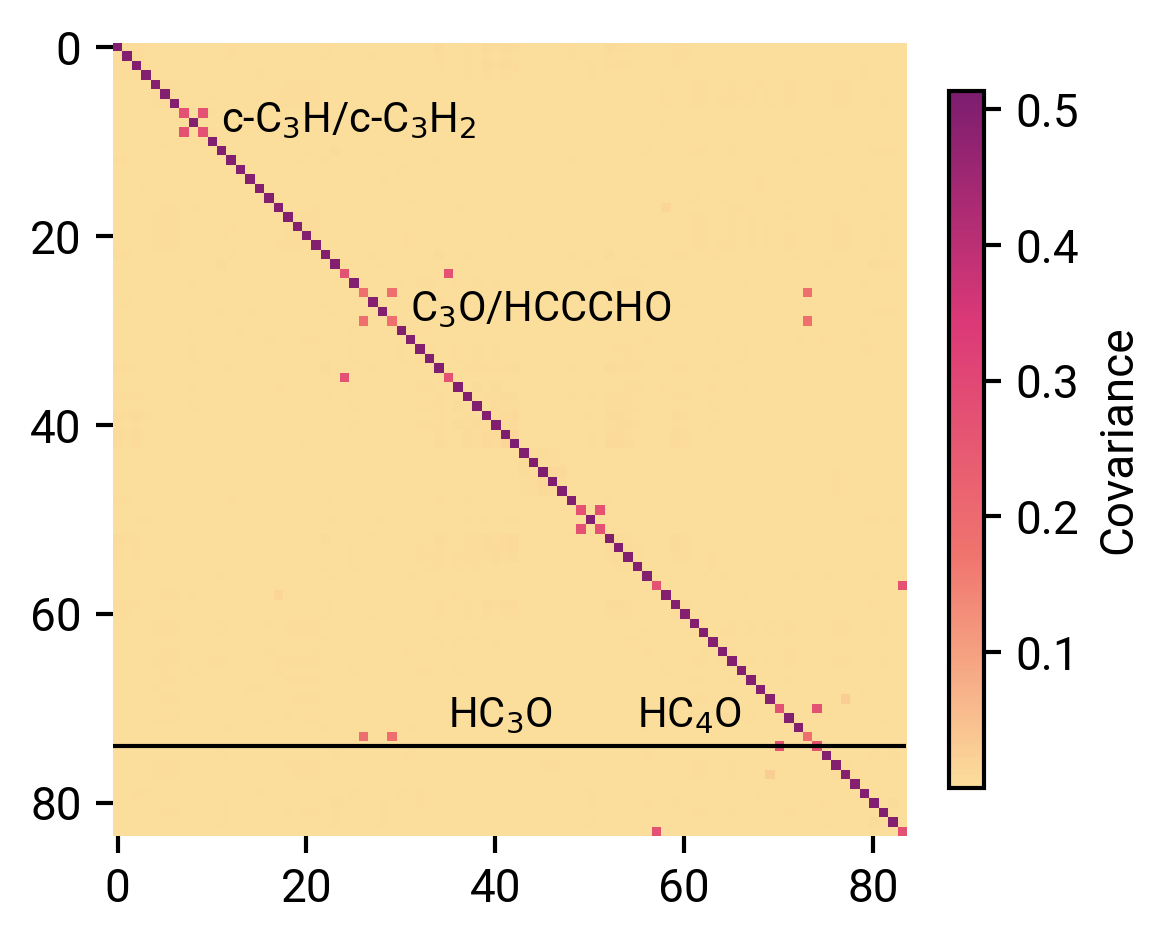

In [134]:
fig, ax = plt.subplots(figsize=(4,4))

hurr = ax.imshow(np.abs(gp_tmc_cov), cmap=SunsetDark_4.get_mpl_colormap())#, norm=LogNorm(vmin=10, vmax=gp_tmc_cov.max()))

cb = fig.colorbar(hurr, ax=ax, fraction=0.04)
cb.ax.set_ylabel("Covariance")
# ax.set(xticks=[], yticks=[])
# ax.set(xlim=[60,80],ylim=[60,80])
ax.text(11, 9, "c-C$_3$H/c-C$_3$H$_2$")
ax.text(31, 29, "C$_3$O/HCCCHO")
ax.text(55, 72, "HC$_4$O")
ax.text(35, 72, "HC$_3$O")
ax.axhline(74.)
for spine in ["left", "bottom"]:
    ax.spines[spine].set_visible(False)

fig.savefig("../../reports/figures/gp_tmc1_covariance.pdf", dpi=100, transparent=True)
fig.savefig("../../reports/figures/gp_tmc1_covariance.svg", dpi=150, transparent=True)

## UMAP viz

In [135]:
manifold_model = UMAP(n_neighbors=20, random_state=42, metric="cosine")

# train on context of cluster
manifold_model.fit(tmc1_embedding)

UMAP(angular_rp_forest=True, metric='cosine', n_neighbors=20, random_state=42)

In [136]:
# project TMC-1 molecules onto cluster manifold
# tmc1_rep = manifold_model.transform(tmc1_embedding)
all_rep = manifold_model.transform(all_pca)

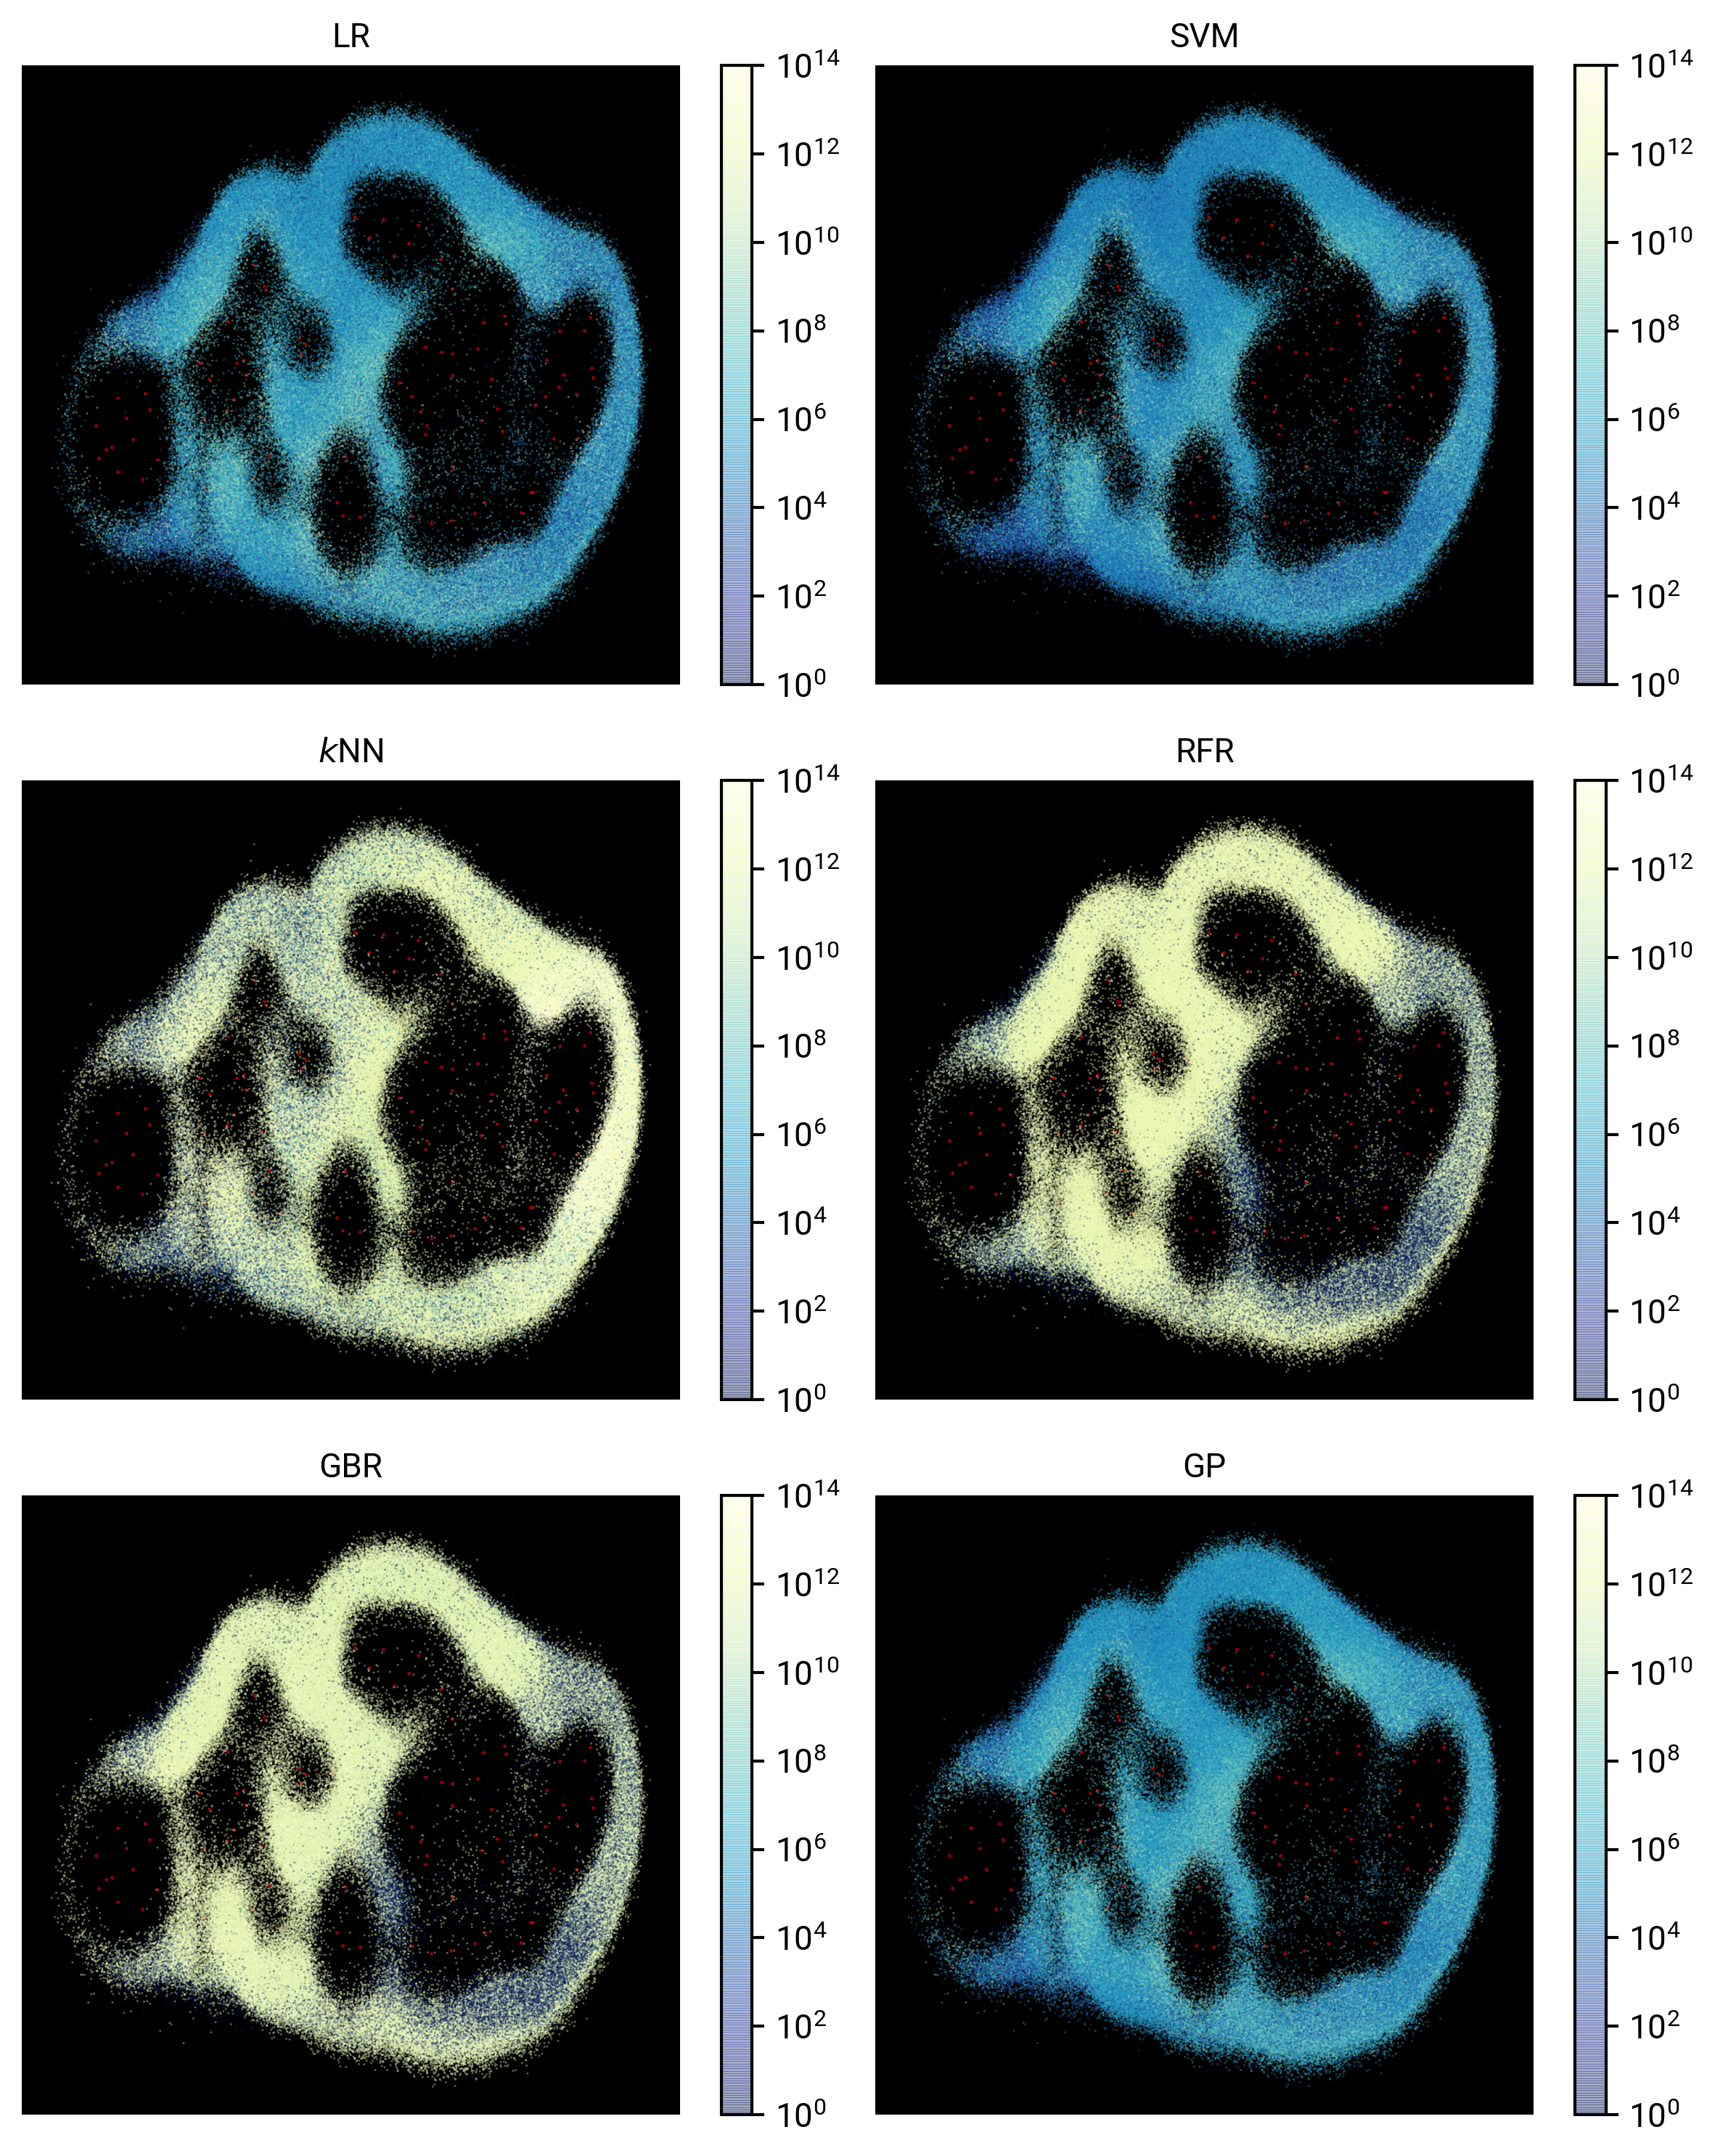

In [142]:
fig, axarray = plt.subplots(3, 2, figsize=(8, 10))

columns = [linear_cols, svm_cols, knn_cols, rfr_cols, gbr_cols, gp_cols]
names = ["LR", "SVM", "$k$NN", "RFR", "GBR", "GP"]

for ax, name, column in zip(axarray.ravel(), names, columns):
    ax.set_facecolor('k')
    ax.scatter(manifold_model.embedding_[:,0], manifold_model.embedding_[:,1], s=1., lw=0.1, alpha=0.6, color="r")
    plot = ax.scatter(all_rep[:,0], all_rep[:,1], s=0.5, c=10**column, cmap="YlGnBu_r", norm=LogNorm(vmin=1., vmax=1e14), alpha=0.4, lw=0.)
#     ax.scatter(manifold_model.embedding_[dist_mask,0], manifold_model.embedding_[dist_mask,1], s=10., marker="x", c="w", alpha=0.4, lw=0.5)
    ax.set(title=name, xticks=[], yticks=[])
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)

    fig.colorbar(plot, ax=ax)
    
fig.savefig("../../reports/figures/full_estimator_comparison.png", dpi=150, transparent=True)
# fig.savefig("../../reports/figures/full_estimator_comparison.svg", dpi=100)

In [91]:
import plotly.express as px
from plotly import graph_objs as go

In [105]:
names = data["smiles"][:]

In [106]:
fig = go.Figure(
    data=[go.Scattergl(
         x=all_rep[:,0],
         y=all_rep[:,1],
        mode="markers",
        opacity=0.4,
        text=names,
        marker={
            "color": gbr_cols,
            "colorscale": "Viridis",
            "colorbar": dict(thickness=20)
        },
        name="Gradient Boosting"
    ),
         go.Scattergl(
             x=manifold_model.embedding_[:,0],
            y=manifold_model.embedding_[:,1],
             mode="markers",
             opacity=0.9,
             text=tmc1_df["SMILES"],
             name="TMC-1"
         )
         ],
    layout={
        "paper_bgcolor": 'rgba(0,0,0,0)',
        "plot_bgcolor": 'rgba(0,0,0,0)',
        "xaxis": {"zeroline": False, "showline": False, "mirror": True},
        "yaxis": {"zeroline": False, "showline": False, "mirror": True}
    }
)

In [107]:
fig.write_html("interactive-all-predict.html", include_plotlyjs="cdn")